### <font color='darkblue'>I. Mounting G-Drive</font>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# Suppress warnings
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")

# Supress tensorflow warnings
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#### <font color='darkblue'>II. Import all the necessary custom modules</font>

In [3]:
# Copying files to the runtime from gdrive
!cp "/content/drive/MyDrive/Colab Notebooks/helper_mnist.py" "/content"
!cp "/content/drive/MyDrive/Colab Notebooks/data_creation.py" "/content"
!cp "/content/drive/MyDrive/Colab Notebooks/network_architecture.py" "/content"
!cp "/content/drive/MyDrive/Colab Notebooks/evaluate_func.py" "/content"

# Importing custom modules and all associated constituent components
import helper_mnist 
import evaluate_func
import network_architecture
import data_creation

from helper_mnist import *
from evaluate_func import *
from network_architecture import *
from data_creation import *

#### <font color='darkblue'>III. Checking GPU Status</font>

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Oct 16 18:22:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W /  70W |    312MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### <font color='darkblue'>IV. For Reproducible Results (using GPU): reset seeds and reset global tensorflow sessions</font>




In [5]:
# Set seed_value
seed_value = 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)  

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
if tf.__version__[0] == '2':
    tf.compat.v1.set_random_seed(seed_value)
    tf.random.set_seed(seed_value)
else:
    tf.set_random_seed(seed_value)

# 5. For working on GPUs from "TensorFlow Determinism"
os.environ["TF_DETERMINISTIC_OPS"] = "1"   # Set True

# 6. Configure a new global `tensorflow` session
if tf.__version__[0] == '2': 
  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
  tf.compat.v1.keras.backend.set_session(sess)
else:
  session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
  tf.compat.v1.keras.backend.set_session(sess)

#### <font color='darkblue'>V. Checking Tensorflow version</font>

In [6]:
%tensorflow_version 2.x
import tensorflow
print(tensorflow.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.9.2


#### <font color='darkblue'>VI. Importing additional necessary libraries</font>

In [7]:
from pathlib import Path
import os
import os.path
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
import time
import random
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from PIL import Image



## <font color='purple'>1. Data Understanding<font color='Purple'>

#### <font color='darkblue'>1.1 Process to load MNIST dataset into the runtime (store train and test datasets)</font>

In [8]:
# Import MNIST dataset from Keras Datasets and loading data
from tensorflow.keras.datasets import mnist
(train_imgs, train_imgs_labels), (test_imgs, test_imgs_labels) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


#### <font color='darkblue'>1.2 Analyzing frequency of unique numbers in the train dataset (before split)</font>

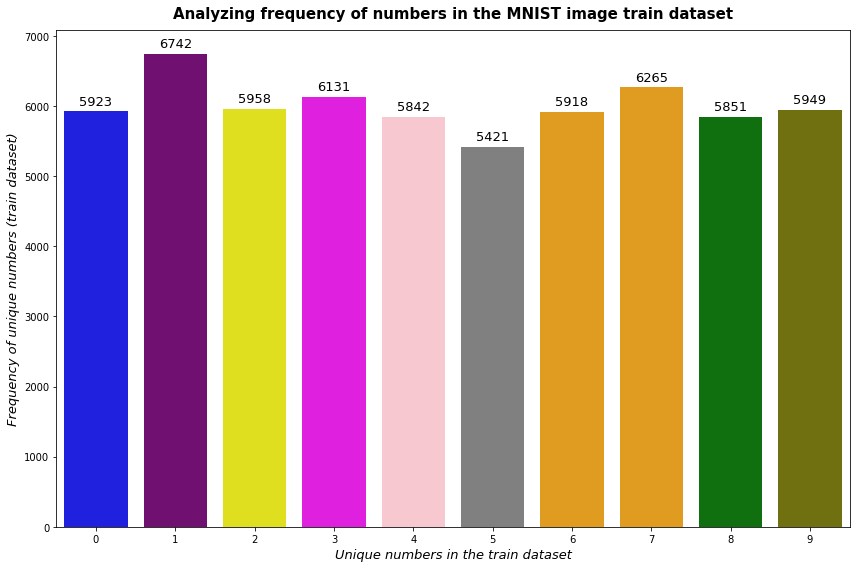

In [9]:
# Checking for class imbalance (before split)

# Analyzing frequency of unique numbers in the train dataset (before split)
magic_helper.freq_plot_image_unique_num(train_imgs_labels)

**Observation**:<br>From the train dataset, it is evident that the proportion of digit images belonging to each image class label are distributed evenly (approximately).

#### <font color='darkblue'>1.3 Splitting the train dataset into training and validation sets</font>

In [10]:
# Splitting the train dataset into training and validation sets (for ease with respect to random number generated values)
from sklearn.model_selection import train_test_split

# 80:20 - split train into training and validation sets (using stratified split)
training_imgs, validation_imgs, training_imgs_labels, validation_imgs_labels = train_test_split(train_imgs, 
                                                                                                train_imgs_labels, 
                                                                                                stratify=train_imgs_labels,
                                                                                                test_size=0.2, 
                                                                                                random_state=42)

In [11]:
# Checking training, validation and test images dimensions and type.
new_line='\n'
tab = '\t'
print(f"Train image dataset size     : {training_imgs.shape}{tab}{type(training_imgs)}")
print(f"Train labels size            : {training_imgs_labels.shape}{tab}{tab}{type(training_imgs_labels)}{new_line}{new_line}")
print(f"Validation image dataset size: {validation_imgs.shape}{tab}{type(validation_imgs)}")
print(f"Validation labels size       : {validation_imgs_labels.shape}{tab}{tab}{type(validation_imgs_labels)}{new_line}{new_line}")
print(f"Test image dataset size      : {test_imgs.shape}{tab}{type(test_imgs)}")
print(f"Test labels size             : {test_imgs_labels.shape}{tab}{tab}{type(test_imgs_labels)}{new_line}{new_line}")

Train image dataset size     : (48000, 28, 28)	<class 'numpy.ndarray'>
Train labels size            : (48000,)		<class 'numpy.ndarray'>


Validation image dataset size: (12000, 28, 28)	<class 'numpy.ndarray'>
Validation labels size       : (12000,)		<class 'numpy.ndarray'>


Test image dataset size      : (10000, 28, 28)	<class 'numpy.ndarray'>
Test labels size             : (10000,)		<class 'numpy.ndarray'>




#### <font color='darkblue'>1.4 Plotting instances of random training images</font>

Random instances of MNIST images from training dataset:



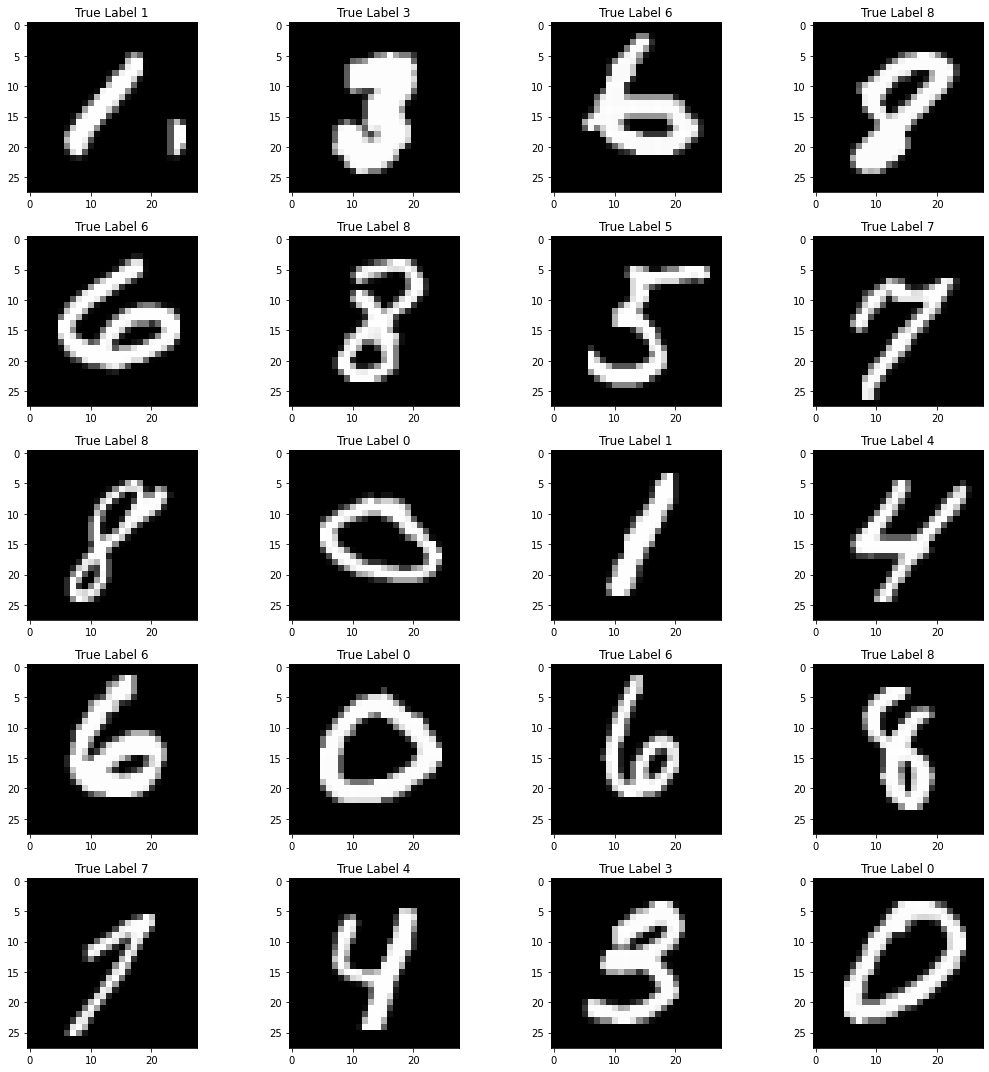

In [12]:
# Plot 20 instances of random training images with their respective true class labels
magic_helper.plot_rand_training_imgs_20_samples(training_imgs, 
                                            training_imgs_labels,
                                            my_color = 'gray')

#### <font color='darkblue'>1.5 Checking training, validation and test image dataset statistics</font>

In [13]:
# Check statistics of training, validation and test datasets

print("Training Image size:                        :", training_imgs[0].shape)
print("Number of Images in Training Dataset:       :", training_imgs.shape[0])
print("Training Image Dataset - Mean pixel value   :", np.mean(training_imgs))
print("Training Image Dataset - Standard Deviation :", np.std(training_imgs))
print("Training Image Dataset - Min pixel value    :", np.min(training_imgs))
print("Training Image Dataset - Max pixel value    :", np.max(training_imgs));print()

print("Validation Image size:                        :", validation_imgs[0].shape)
print("Number of Images in Validation Dataset:       :", validation_imgs.shape[0])
print("Validation Image Dataset - Mean pixel value   :", np.mean(validation_imgs))
print("Validation Image Dataset - Standard Deviation :", np.std(validation_imgs))
print("Validation Image Dataset - Min pixel value    :", np.min(validation_imgs))
print("Validation Image Dataset - Max pixel value    :", np.max(validation_imgs));print()

print("Test Image size:                        :", test_imgs[0].shape)
print("Number of Images in Test Dataset:       :", test_imgs.shape[0])
print("Test Image Dataset - Mean pixel value   :", np.mean(test_imgs))
print("Test Image Dataset - Standard Deviation :", np.std(test_imgs))
print("Test Image Dataset - Min pixel value    :", np.min(test_imgs))
print("Test Image Dataset - Max pixel value    :", np.max(test_imgs))

Training Image size:                        : (28, 28)
Number of Images in Training Dataset:       : 48000
Training Image Dataset - Mean pixel value   : 33.35111325467687
Training Image Dataset - Standard Deviation : 78.60129135177951
Training Image Dataset - Min pixel value    : 0
Training Image Dataset - Max pixel value    : 255

Validation Image size:                        : (28, 28)
Number of Images in Validation Dataset:       : 12000
Validation Image Dataset - Mean pixel value   : 33.18765423044218
Validation Image Dataset - Standard Deviation : 78.4320025736005
Validation Image Dataset - Min pixel value    : 0
Validation Image Dataset - Max pixel value    : 255

Test Image size:                        : (28, 28)
Number of Images in Test Dataset:       : 10000
Test Image Dataset - Mean pixel value   : 33.791224489795916
Test Image Dataset - Standard Deviation : 79.17246322228644
Test Image Dataset - Min pixel value    : 0
Test Image Dataset - Max pixel value    : 255


**Observations:**<br>1. **Pixel values are integer values between 0 and 255**<br>2. The **mean and standard deviation** of the pixel values **are similar between the training, validation and test datasets**

#### <font color='darkblue'>1.6 Analyzing the effect of normalization (scaling) on a sample training image</font>


Comparing original and normalized MNIST image sample:



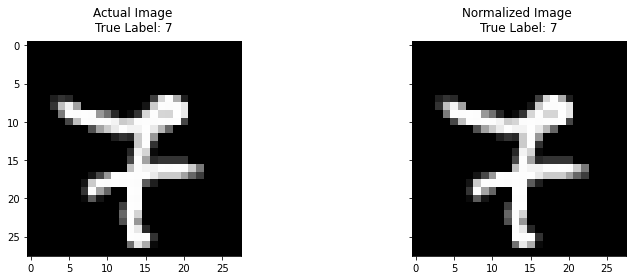

In [14]:
# Analyzing the effect of normalization (scaling) on a sample training image
magic_helper.plot_scaling_effect_training_img(training_imgs, training_imgs_labels, sample_idx=100)

**Observation:**<br>The net effect of **'normalization'** can be seen in the second normalized image. We will **normalize images later** using ***'Image Data Generators'***.

## <font color='purple'>2. Data Preparation and Manipulation</font>

#### <font color='darkblue'>2.1 Dataset Creation : Transforming data into the desired format</font>

In [15]:
# Instantiating 'data_creation' class from 'data_creation.py'
data_create = data_creation(training_imgs, training_imgs_labels, 
                              validation_imgs, validation_imgs_labels, 
                              test_imgs, test_imgs_labels)

# Reshaping Training, Validation and Test Image to avoid dimension error --> inputs_a
training_imgs, validation_imgs, test_imgs = data_create.reshape_imgs_data()

# One-hot encoded Image Class Labels (0-9) --> True one-hot encoded labels of Inputs_a
training_imgs_labels, validation_imgs_labels, test_imgs_labels = data_create.categorical_encoded_imgs_labels()

# One-hot encoded random numbers list (0-9) --> True one-hot encoded random number --> inputs_b
training_randnum_list, validation_randnum_list, test_randnum_list = data_create.randnum_encoded_list(randnum_labels_print=True)

# One-Hot encoded true summed output (0-18) 19 classes
training_sum_labels_encoded, validation_sum_labels_encoded, test_sum_labels_encoded = data_create.summed_output_encoded_true_labels(summed_encoded_print = True)


----------------------------------------------------------------------------------------------------
Reshaped Training Image Dataset Dimensions   :  (48000, 28, 28, 1)
Reshaped Validation Image Dataset Dimensions :  (12000, 28, 28, 1)
Reshaped Test Image Dataset Dimensions       :  (10000, 28, 28, 1)
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Training Image Labels - One-hot encoded Matrix Size   :  (48000, 10)
Validation Image Labels - One-hot encoded Matrix Size :  (12000, 10)
Test Image Labels - One-hot encoded Matrix Size       :  (10000, 10)
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
(One-Hot Encoded) Training Random Number List Dimensions   :  (48000, 10)
(One-Hot E

#### <font color='darkblue'>2.2 Image Data Generators</font>

#### <font color='maroon'>A. Image Data Generators:</font><br> 
- Three data generators are created for respective image datasets 
and the images are rescaled/normalized. <br><br>

#### <font color='maroon'>B. Data Augmentation:</font><br> 
- Augmentation is conducted on the training image data samples. 
- Random training samples are automatically subjected to transformations like: *rotation range (degree range: 5) along with height and width shift range of 5%  and zoom_range of 5%, to introduce variation in the training image dataset.*

In [16]:
# Setting batch size
MY_BATCH_SIZE = 128

# Using Image Data Generators -> For Images Dataset 
# Incorporating 'mnist_image_data_generator' class from custom module 'data_creation.py'        
image_data_generator = mnist_image_data_generator(                              # Instantiating a class
                                training_imgs, training_imgs_labels,
                                validation_imgs, validation_imgs_labels,
                                test_imgs, test_imgs_labels,
                                batch_size = MY_BATCH_SIZE)


# Image Data Generator for Training Data
# --> Normalization, data augmentation and  iterating over batches
training_imgs_generator = image_data_generator.training_imgs_generator()

# Image Data Generator for Validation Data --> Generates normalized Images in batches
validation_imgs_generator = image_data_generator.validation_imgs_generator()

# Image Data Generator for Test Data --> Generates normalized Images in batches
test_imgs_generator = image_data_generator.test_imgs_generator()


## <font color='purple'>3. Model (Network) Building</font>

#### <font color='darkblue'>3.1 Model Configuration and Keras Callbacks (for optimizing training routine)</font>

In [17]:
# Model Configuration
EPOCHS= 100
BATCH_SIZE = MY_BATCH_SIZE
INPUT_IMG_SIZE = (28,28,1)
INPUT_RANDNUM_SIZE = (10)
NUM_OF_IMG_CLASSES = 10
NUM_OF_SUM_CLASSES = 19
RAND_NUM_CLASSES = 10

# Necessary Keras Callbacks
# 1. ReduceLROnPlateau Callback (Learning Rate Scheduler -> Decays LR)
reduce_lr_callback = ReduceLROnPlateau(
                          monitor='val_loss', 
                          factor=0.3,               # Factor by which LR is reduced (for decay) -> new_lr = lr * factor
                          cooldown=1, 
                          patience=2,
                          verbose=1)
# 2. EarlyStopping Callback
early_stopping_callback = EarlyStopping(
                          monitor='val_loss',
                          patience=5,
                          mode='min',
                          restore_best_weights=False) 

# 3. ModelCheckpoint callback 
checkpoint_filepath = '/content/model_chkpoints/model-{epoch:02d}-{loss:.5f}-{class_img_outputs_loss:.5f}-{class_summed_outputs_loss:.5f}-{class_img_outputs_accuracy:.5f}-{class_summed_outputs_accuracy:.5f}-{val_loss:.5f}-{val_class_img_outputs_loss:.5f}-{val_class_summed_outputs_loss:.5f}-{val_class_img_outputs_accuracy:.5f}-{val_class_summed_outputs_accuracy:.5f}.hdf5'
model_checkpoint_callback = ModelCheckpoint(
                          filepath=checkpoint_filepath,
                          save_weights_only=False,  # Save complete model
                          monitor='val_loss',
                          mode='min',
                          verbose=1,
                          save_best_only=True)    # Save only the best models

# # 4. CSVLogger callback  
csv_logger_callback = CSVLogger('/content/model_chkpoints/training_history.log',
                          separator=',', 
                          append=True) # append=True (Starts with an empty file and records data)

# Callbacks List                        
CALLBACKS_LIST = [reduce_lr_callback, early_stopping_callback, model_checkpoint_callback, csv_logger_callback]

# Removing 'model' variable (if any)
if "model" in globals():
  del model
else:
  pass

# Optimizing session, memory storage and tensorflow session components
magic_helper.optimize_session()


#### <font color='darkblue'>3.2 Building 'Combined_MNIST_Image_Classification_and_Summed_Output' Model</font>

In [18]:
# Creating an instance of network architecture class from 'network_architecture.py'
network_arch = network_architecture(INPUT_IMG_SIZE, 
                                    NUM_OF_IMG_CLASSES, 
                                    INPUT_RANDNUM_SIZE, 
                                    NUM_OF_SUM_CLASSES)

# Building a complete network (MNIST Image Classification + Summed Output)
model = network_arch.build_img_class_n_summed_output_model()

# Losses (For both the outputs)
LOSSES = {"class_img_outputs": "categorical_crossentropy",     # One-hot encoded labels 0-9
          "class_summed_outputs": "categorical_crossentropy"}  # One-hot encoded labels 0-18

# Assigning equal Loss Weights (To both outputs)
LOSS_WEIGHTS = {"class_img_outputs": 1.0, "class_summed_outputs": 1.0}   

# Metrics
METRICS = {"class_img_outputs": "accuracy", "class_summed_outputs": "accuracy"}

# Compile the model before training
model.compile(optimizer= Adam(),
            loss = LOSSES,
            loss_weights = LOSS_WEIGHTS,      
            metrics= METRICS)
  
# Display Model Summary
print(model.summary());print()

Model: "Combined_MNIST_Image_Classification_and_Summed_Output_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs_a (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 24, 24, 32)   832         ['inputs_a[0][0]']               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 20, 20, 32)   25632       ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 20, 20, 32)  128         ['conv2d_1[0][0]']               
 alization)                             

#### <font color='darkblue'>3.3 'Combined_MNIST_Image_Classification_and_Summed_Output' Model Architecture Plot</font>

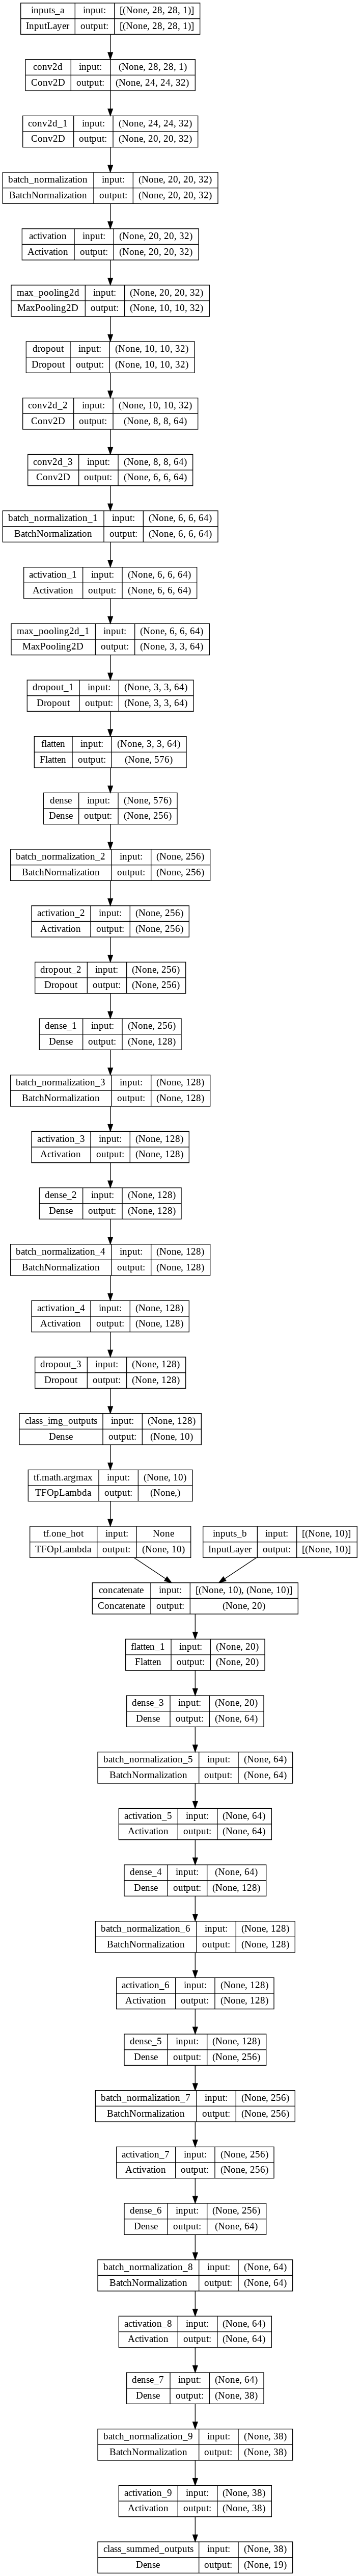

In [19]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### <font color='darkblue'>3.4 Model Training</font>

In [20]:
# # --> Run this cell only during model training (comment-out while loading the saved model)

# Fit data to model 
history = model.fit(
            x = {'inputs_a': training_imgs_generator.x, 'inputs_b':training_randnum_list},
            y = {'class_img_outputs': training_imgs_generator.y, 
                'class_summed_outputs':training_sum_labels_encoded},
            validation_data = [{'inputs_a':validation_imgs_generator.x, 'inputs_b':validation_randnum_list},
                  {'class_img_outputs': validation_imgs_generator.y, 
                  'class_summed_outputs':validation_sum_labels_encoded}], 
            batch_size = BATCH_SIZE, epochs= EPOCHS, 
            callbacks = CALLBACKS_LIST, verbose=1)

Epoch 1/100
371/375 [============================>.] - ETA: 0s - loss: 1.0063 - class_img_outputs_loss: 0.3183 - class_summed_outputs_loss: 0.6879 - class_img_outputs_accuracy: 0.9038 - class_summed_outputs_accuracy: 0.8793
Epoch 1: val_loss improved from inf to 0.27141, saving model to /content/model_chkpoints/model-01-0.99987-0.31637-0.68350-0.90440-0.88017-0.27141-0.05536-0.21605-0.98358-0.98358.hdf5
375/375 [==============================] - 16s 16ms/step - loss: 0.9999 - class_img_outputs_loss: 0.3164 - class_summed_outputs_loss: 0.6835 - class_img_outputs_accuracy: 0.9044 - class_summed_outputs_accuracy: 0.8802 - val_loss: 0.2714 - val_class_img_outputs_loss: 0.0554 - val_class_summed_outputs_loss: 0.2161 - val_class_img_outputs_accuracy: 0.9836 - val_class_summed_outputs_accuracy: 0.9836 - lr: 0.0010
Epoch 2/100
375/375 [==============================] - ETA: 0s - loss: 0.2769 - class_img_outputs_loss: 0.0840 - class_summed_outputs_loss: 0.1928 - class_img_outputs_accuracy: 0.97

#### <font color='darkblue'>3.5 Plotting Model Training Performance</font>

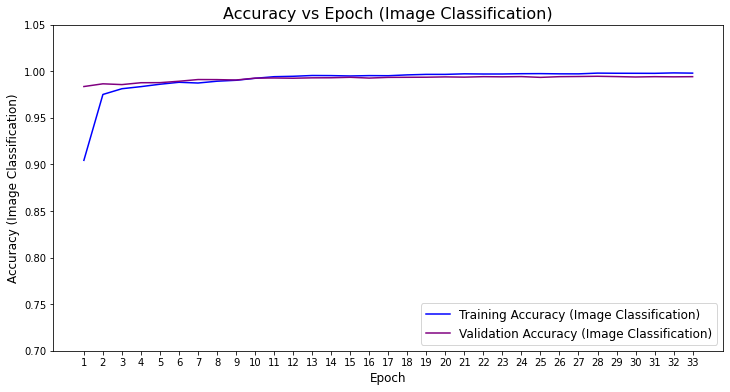


****************************************************************************************************
                         Model Training Plots
****************************************************************************************************




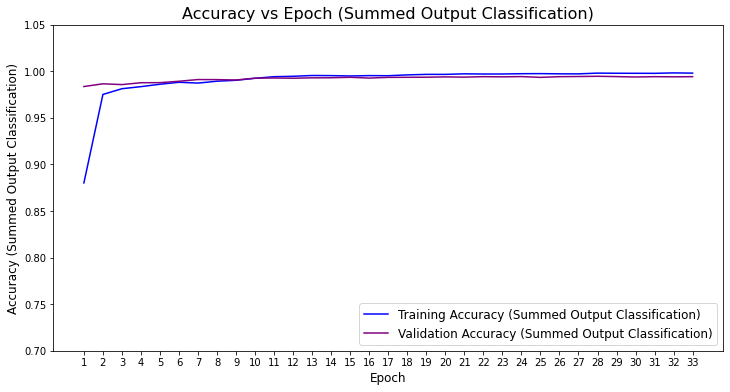




****************************************************************************************************



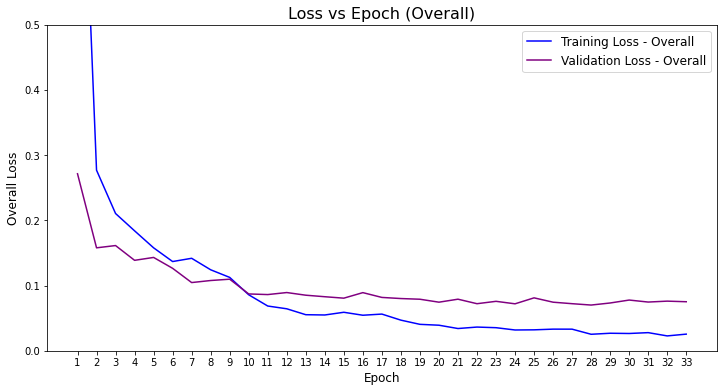

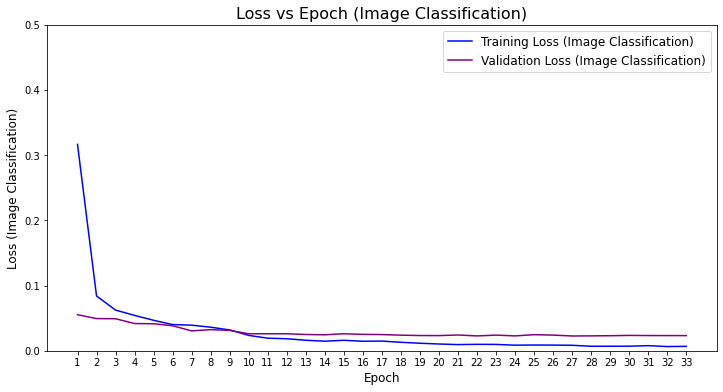

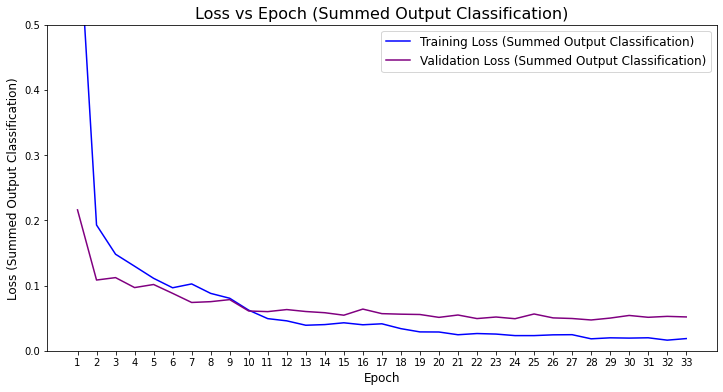


****************************************************************************************************


In [21]:
# # --> Run this cell only during model training (comment-out while loading the saved model)

# Plotting Model Training Performance 
magic_helper.plot_model_training_performance(history)

## <font color='purple'>4. Model Evaluation</font>

#### <font color='darkblue'>4.1 Load the best trained model</font>

In [22]:
# # --> Run this cell only during model training (comment-out while loading the saved model)

# # Getting model path of the best performing model 
# Checking content within the 'model_chkpoints' directory
file_names = os.listdir("/content/model_chkpoints")
best_mod_epoch_num = sorted([int(name.split("-")[1]) for name in file_names if name.startswith("model-")], reverse=True)[0]
best_model_name = [name for name in file_names if name.startswith("model-"+str(best_mod_epoch_num))][0]
print('\033[1m'+"Best Model Name: ", best_model_name,'\033[0m'); print()

# Retrieve best model training and validation results
training_results = model_training_results()        # Instantiate a class object of class 'model_training_results'
training_results.retrieve_best_model_training_scores(best_model_name)

# Best model path
load_model_path= "/content/model_chkpoints/"+str(best_model_name)

# Loading the best model
model = load_model(load_model_path)


Best Model Name:  model-28-0.02534-0.00696-0.01837-0.99798-0.99798-0.07013-0.02289-0.04725-0.99458-0.99458.hdf5 

Training Accuracy (Image Labels)           : 99.7980 %
Training Accuracy (Summed Output Labels)   : 99.7980 %
Overall Training Loss                      : 0.0253 
Training Loss (Image Labels)               : 0.0070
Training Loss (Summed Output Labels)       : 0.01837

Validation Accuracy (Image Labels)         : 99.4580 %
Validation Accuracy (Summed Output Labels) : 99.4580 %
Overall Validation Loss                    : 0.0701 
Validation Loss (Image Labels)             : 0.0229
Validation Loss (Summed Output Labels)     : 0.04725



#### <font color='darkblue'>*** (Uncomment this cell) To load saved model</font>

In [23]:
# # --> Uncomment this cell to load saved model (alter the paths accordingly)

# !mkdir "/content/model_chkpoints"
# !cp "/content/drive/MyDrive/Colab Notebooks/model.zip" "/content/model_chkpoints/"
# !unzip -d "/content/model_chkpoints/model" "/content/model_chkpoints/model.zip"
# # Load the best model
# from tensorflow.keras.models import load_model
# model_path = '/content/model_chkpoints/model'     
# model = load_model(model_path)

#### <font color='darkblue'>4.2 Evaluate the performance of the best trained model on test dataset</font>

In [24]:
# Evaluating best model performance on test dataset
eval_func.evaluate_model_test_set(
                        model, batch_size = BATCH_SIZE, 
                        inputs_a = test_imgs_generator.x, 
                        inputs_b = test_randnum_list, 
                        class_img_outputs = test_imgs_generator.y, 
                        class_summed_outputs = test_sum_labels_encoded)

# Optimizing session
magic_helper.optimize_session()

Test Accuracy (Image Labels)               : 99.5400 %
Test Accuracy (Summed Output Labels)       : 99.5400 %
Overall Test Loss                          : 0.0559 
Test Loss (Image Labels)                   : 0.0169
Test Loss (Summed Output Labels)           : 0.0389


#### <font color='darkblue'>4.3 Confusion Matrices and Classification Reports</font>


========= CONFUSION MATRIX AND CLASSIFICATION REPORT - (Image Classification) TEST SET ==========



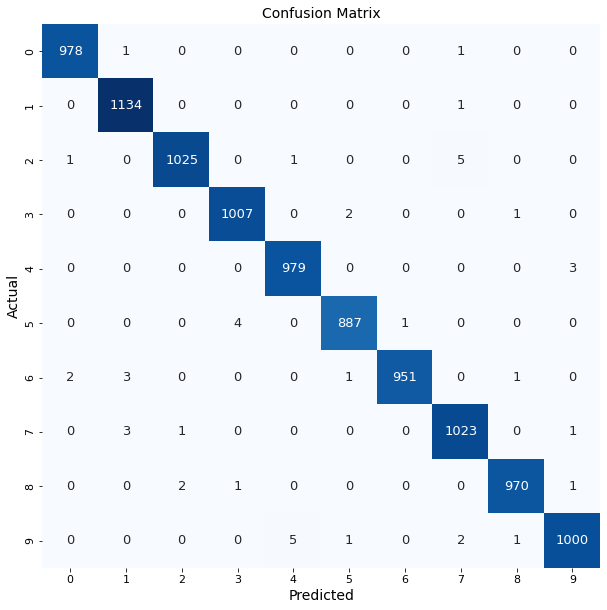


***************   Classification Report   ***************
              precision    recall  f1-score   support

           0     0.9969    0.9980    0.9975       980
           1     0.9939    0.9991    0.9965      1135
           2     0.9971    0.9932    0.9951      1032
           3     0.9951    0.9970    0.9960      1010
           4     0.9939    0.9969    0.9954       982
           5     0.9955    0.9944    0.9950       892
           6     0.9989    0.9927    0.9958       958
           7     0.9913    0.9951    0.9932      1028
           8     0.9969    0.9959    0.9964       974
           9     0.9950    0.9911    0.9930      1009

    accuracy                         0.9954     10000
   macro avg     0.9955    0.9953    0.9954     10000
weighted avg     0.9954    0.9954    0.9954     10000



========= CONFUSION MATRIX AND CLASSIFICATION REPORT - (Summed Output Classification) TEST SET ==========



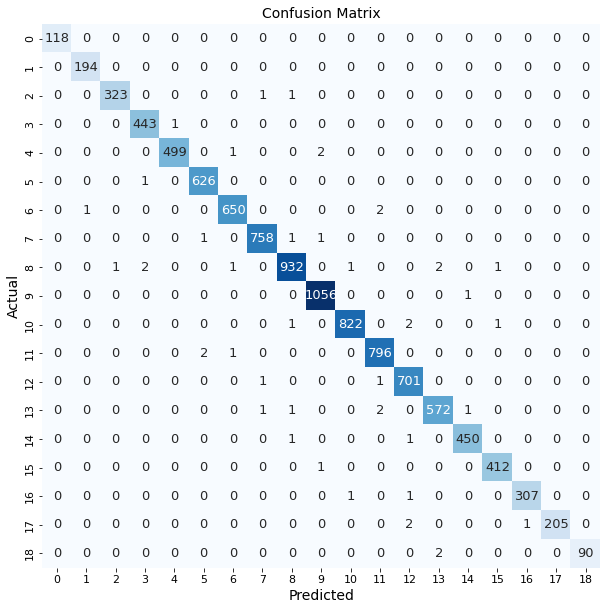


***************   Classification Report   ***************
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       118
           1     0.9949    1.0000    0.9974       194
           2     0.9969    0.9938    0.9954       325
           3     0.9933    0.9977    0.9955       444
           4     0.9980    0.9940    0.9960       502
           5     0.9952    0.9984    0.9968       627
           6     0.9954    0.9954    0.9954       653
           7     0.9961    0.9961    0.9961       761
           8     0.9947    0.9915    0.9931       940
           9     0.9962    0.9991    0.9976      1057
          10     0.9976    0.9952    0.9964       826
          11     0.9938    0.9962    0.9950       799
          12     0.9915    0.9972    0.9943       703
          13     0.9931    0.9913    0.9922       577
          14     0.9956    0.9956    0.9956       452
          15     0.9952    0.9976    0.9964       413
          16     0.996

In [25]:
# 1. Model Predictions - Image Classification 

# Converting one-hot encoded image labels to predicted 'int' labels
encoded_both_pred = model.predict(x = {'inputs_a': test_imgs_generator.x, 'inputs_b': test_randnum_list}, verbose=0)
imgs_predictions = np.array([np.argmax(i, axis=1) for i in encoded_both_pred][0])   # Image predictions

# Corresponding True image'int' labels
test_imgs_gen_labels = np.array([np.argmax(i) for i in test_imgs_generator.y])         

# Plot confusion matrix and classification report for test results
eval_func.confusion_mtx_and_class_report(test_imgs_gen_labels, imgs_predictions, 
                                         NUM_OF_IMG_CLASSES, "Image Classification");print()




# 2. Model Predictions - Summed Output Classification
# Converting one-hot encoded summed output to predicted 'int' labels
summed_output_pred = np.array([np.argmax(i, axis=1) for i in encoded_both_pred][1])   # Summed Output predictions

# Corresponding True summed output 'int' labels
test_summed_op_labels = np.array([np.argmax(i) for i in test_sum_labels_encoded])    

# Plot confusion matrix and classification report for test results
eval_func.confusion_mtx_and_class_report(test_summed_op_labels, summed_output_pred, 
                                         NUM_OF_SUM_CLASSES, "Summed Output Classification");print()

#### <font color='darkblue'>4.4 Visualizing few of the misclassified image samples from the test dataset</font>

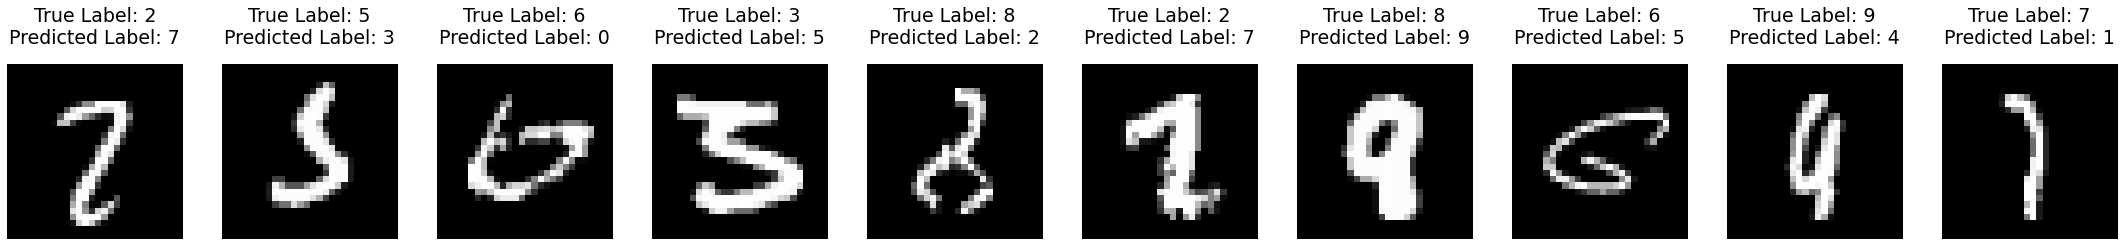

In [26]:
# Misclassified image indices, true labels and predicted labels
misclass_imgs_indices = [idx for idx, (i,j) in enumerate(zip(imgs_predictions, test_imgs_gen_labels)) if i!=j]
misclass_imgs_true = np.take(test_imgs_gen_labels, misclass_imgs_indices)
misclass_imgs_pred = np.take(imgs_predictions, misclass_imgs_indices)   

# Visualizing few of the misclassified image samples from the test dataset
magic_helper.visualize_ten_misclassified_samples(test_imgs_generator.x,  # Test Image dataset
                                                 misclass_imgs_indices, 
                                                 misclass_imgs_true, 
                                                 misclass_imgs_pred)

**Observations:**

From the above visualization, 
- It is **evident that the misclassified images have an ambiguous appearance**
- These images **do not closesly resemble to the actual numbers listed under their respective true labels**. Hence, **minuscule portion of the number labels were misclassified due to bad data quality**. 
- Also, these images **can be easily misconstrued even by a human** interpreter.

#### <font color='darkblue'>*** Saving the best model</font>

In [27]:
# Save best model 
model.save('/content/model_chkpoints/model/')

# zip contents of the best model along with its architecture (complete model)
!zip -r /content/model_chkpoints/model.zip /content/model_chkpoints/model

  adding: content/model_chkpoints/model/ (stored 0%)
  adding: content/model_chkpoints/model/keras_metadata.pb (deflated 94%)
  adding: content/model_chkpoints/model/variables/ (stored 0%)
  adding: content/model_chkpoints/model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: content/model_chkpoints/model/variables/variables.index (deflated 76%)
  adding: content/model_chkpoints/model/saved_model.pb (deflated 90%)
  adding: content/model_chkpoints/model/assets/ (stored 0%)


## <font color='purple'>Conclusion</font>

In [28]:
# Print all training and evaluation results --> 

# If saved_model_loaded: False -> displays training, validation and evaluation results 
# saved_model_loaded: True -> displays only evaluation scores

saved_model_loaded = False    
if saved_model_loaded==False:
  training_results.retrieve_best_model_training_scores(best_model_name)
eval_func.evaluate_model_test_set(
                        model, batch_size = BATCH_SIZE, 
                        inputs_a = test_imgs_generator.x, 
                        inputs_b = test_randnum_list, 
                        class_img_outputs = test_imgs_generator.y, 
                        class_summed_outputs = test_sum_labels_encoded)

Training Accuracy (Image Labels)           : 99.7980 %
Training Accuracy (Summed Output Labels)   : 99.7980 %
Overall Training Loss                      : 0.0253 
Training Loss (Image Labels)               : 0.0070
Training Loss (Summed Output Labels)       : 0.01837

Validation Accuracy (Image Labels)         : 99.4580 %
Validation Accuracy (Summed Output Labels) : 99.4580 %
Overall Validation Loss                    : 0.0701 
Validation Loss (Image Labels)             : 0.0229
Validation Loss (Summed Output Labels)     : 0.04725

Test Accuracy (Image Labels)               : 99.5400 %
Test Accuracy (Summed Output Labels)       : 99.5400 %
Overall Test Loss                          : 0.0559 
Test Loss (Image Labels)                   : 0.0169
Test Loss (Summed Output Labels)           : 0.0389


#### <font color='darkblue'><br></font>
##### <font color='darkblue'>> The combined MNIST Image classification and summed output classification model achieved equal performances on both the outputs, achieving elevated accuracy scores of 99.798%, 99.458% and 99.54% on training, validation and test datasets respectively. </font><br>
##### <font color='darkblue'>> Since data quality still remains a concern, some ambiguous images which can be even misconstrued by human eye were misinterpreted by the model. However, those were a minuscule portion of the dataset.</font><br>


#### <font color='Purple'>*** Testing Model On Additional Sample Test Inputs (number images and random number inputs)</font>

Archive:  /content/Sample Test Images.zip
   creating: /content/Sample Test Images/
  inflating: /content/Sample Test Images/Number_1_Sample_Input_Img.jpg  
  inflating: /content/Sample Test Images/Number_2_Sample_Input_Img.jpg  
  inflating: /content/Sample Test Images/Number_3_type1_Sample_Input_Img.jpg  
  inflating: /content/Sample Test Images/Number_3_type2_Sample_Input_Img.jpg  
****************************************************************************************************


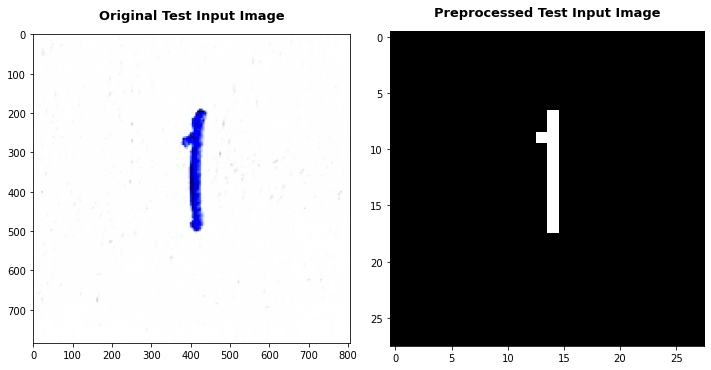


Random Number Input                     : 4
Sample Image Output (Predicted Label 1) : 1
Summed Output (Predicted Label 2)       : 5 

****************************************************************************************************


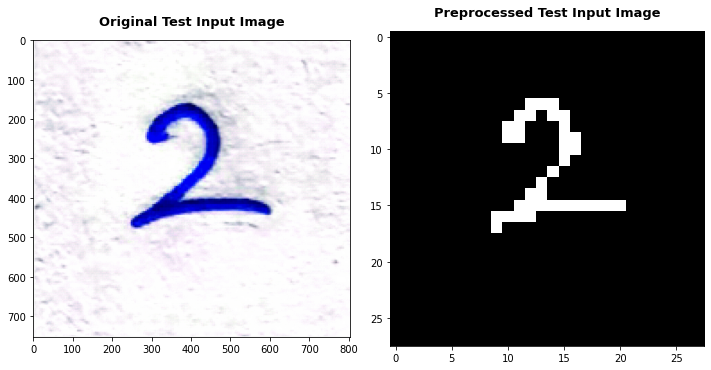


Random Number Input                     : 9
Sample Image Output (Predicted Label 1) : 2
Summed Output (Predicted Label 2)       : 11 

****************************************************************************************************


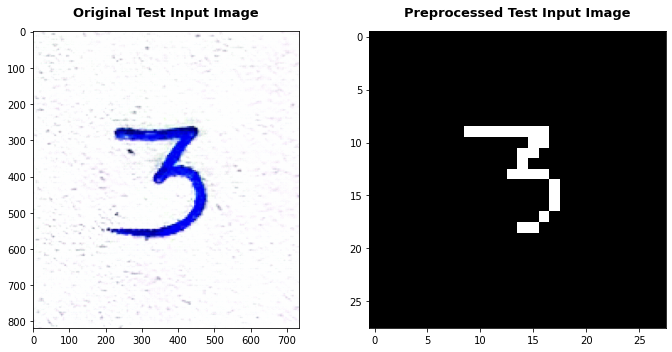


Random Number Input                     : 8
Sample Image Output (Predicted Label 1) : 3
Summed Output (Predicted Label 2)       : 11 

****************************************************************************************************


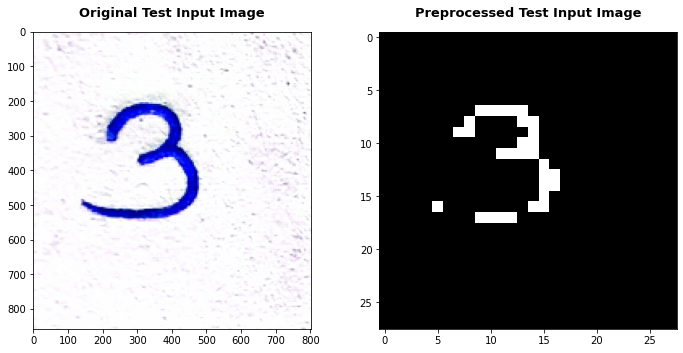


Random Number Input                     : 6
Sample Image Output (Predicted Label 1) : 3
Summed Output (Predicted Label 2)       : 9 

****************************************************************************************************


In [29]:
# Sample Testing: Model Inputs

# Loading the sample test images to Colab runtime (from Gdrive)
!cp "/content/drive/MyDrive/Colab Notebooks/Sample Test Images.zip" "/content/"
!unzip -d "/content/" "/content/Sample Test Images.zip"
!rm -rf "/content/Sample Test Images.zip"


# Evaluating test samples from the 'Sample Test Images' directory (Test Image Paths)
import os
test_img_paths_l= sorted(["/content/Sample Test Images/"+img_name 
                   for img_name in os.listdir("/content/Sample Test Images")])

# Sample Test Random Number Inputs
randnum_l = [4,9,8,6]

# Model testing on sample inputs (Display predicted outputs)
print('*'*100)
for k in range(len(randnum_l)):
  eval_func.predict_mnist_img_n_randnum_summed_op(model, test_img_paths_l[k],
                                      randnum_l[k])

**Observation:**

#### <font color='darkblue'>The best trained model clearly delivers the expected outputs on additional sample test images and random number inputs.</font>